In [5]:
%matplotlib inline
import random
import numpy as np
from matplotlib import pyplot as plt

rpm = 1650 #Cederberg (2023)

f = (83.6 / 0.95 / 0.9 / 0.8) / 110 #ratio between P_engineOut (diesel/hybrid) and P_batteriesOut (a.k.a. P_cons) -
                                    #- calculated for P_cons = 100 kW
    
t_b = 10 #years, battery lifetime
t_f = 25 #years, ferry lifetime

FC = 35
P_cons = 110
P_consICE = f * P_cons
MK1_hv = 35.3


#SMED, 2020 values:
SO2 = 36.0
PM = 0.27 #g / GJ, PM uncertainty: 40%

#CO2_battery: 
#Lower bound value (LBV): 172
#Asymptotic value (ASV): 240
#"Average value" (AVV): 487

#Battery production:

CO2_battery = 240

#Energimyndigheten, 2021 values:
CO2 = 2580 #g CO2 eq. / liter
HVO = 520  #g CO2 eq. / liter

#Electricity mix:
CO2_e = np.linspace(0,50,100)#g CO2 eq. / kWh

#Engine production:
CO2_engine = 37.75 #kg CO2 eq. / kW
kW_engine = 257

#Electric motor production:
CO2_motor = 19.6 #kg CO2 eq. / kW, assumed same kW as engines

#MGO production:
CO2_fuel = 12.5 #kg CO2 eq. / MJ


In [6]:

#IMO Regulation 13:

#CO2, SO2 and PM functions:

def CO2_calc(t_op, e_f):
    CO2_ret = CO2 * FC * t_op * (1 - e_f)  #Diesel part
    CO2_ret += CO2_e * P_cons * t_op * e_f #Electricity part
    return CO2_ret
                        
def emissionCalc(t_op, e_f, tier, rpm): 
    
    CO2_result = CO2_calc(t_op, e_f)
    return CO2_result

def summary4(f1,f2,f3,f4):
    
    res = np.array([f1, f2, f3, f4]) / 1000
    res = res.sum(axis=0)
    
    #print("GHGs: " + str(f'{res[0]:.5f}'))
    #print("NOx: " + str(f'{res[1]:.5f}'))
    #print("SOx: " + str(f'{res[2]:.5f}'))
    #print("PM: " + str(f'{res[3]:.5f}'))
    return res
    
def upstreamCalc(f, kWh_init, kWh, kW, t_op, e_f):
   
        #f[0][i] += (((CO2_battery[i] * kWh) / (t_b[i] * 365)) + ((CO2_engine * kW) / (t_f * 365))) * 1000
    #f += (((CO2_battery * kWh) / (t_b * 365)) + ((CO2_engine * kW) / (t_f * 365))) * 1000
    
        #f[0][i] += ((CO2_battery[i] * kWh) / (t_b[i] * 365)) * 1000 #Battery production
        
    #Battery production: The initial capacity + the replacements 
    f +=  (CO2_battery * (kWh_init + (kWh * (t_f / t_b)))) / (t_f * 365) * 1000         
    #Engine production:
    f += ((CO2_engine * kW) / (t_f * 365)) * 1000
    #Electric motor production: All ferries have two electric motors, assumed to have the same kW as the engines
    f += ((2 * kW_engine * CO2_motor) / (t_f * 365)) / 1000     
    #Fuel production:
    f += ((t_op * (1 - e_f) * FC * MK1_hv * CO2_fuel) / (t_f * 365)) * 1000 
    
    return(f) #grams

In [7]:
#BASELINE
t_op1 = 13
t_op2 = 12.5
t_op3 = 8

e_f1 = 0.6154
e_f2 = 0.5200
e_f3 = 0

ferry1 = emissionCalc(t_op1, e_f1, 3, 1650)
ferry2 = emissionCalc(t_op2, e_f2, 3, 1650)
ferry3 = emissionCalc(t_op3, e_f3, 2, 1650) #returns grams / day
ferry4 = np.zeros(len(CO2_e))

ferry1 = upstreamCalc(ferry1, 1260, 1260, kW_engine, t_op1, e_f1) #returns grams / day
ferry2 = upstreamCalc(ferry2, 1000, 1000, kW_engine, t_op2, e_f2)
ferry3 = upstreamCalc(ferry3, 0, 0, 2 * kW_engine, t_op3, e_f3)
ferry4 = upstreamCalc(ferry4, 0, 0, 2 * kW_engine, 0, 0)

GHG_BASE = summary4(ferry1, ferry2, ferry3, ferry4)

In [8]:
#Big Battery
t_op1 = 11
t_op2 = 10.5
t_op3 = 9
t_op = 3

e_f1 = 1
e_f2 = 1
e_f3 = 1
e_f4 = 1

ferry1 = emissionCalc(t_op1, e_f1, 3, 1650)
ferry2 = emissionCalc(t_op2, e_f2, 3, 1650)
ferry3 = emissionCalc(t_op3, e_f3, 3, 1650)
ferry4 = emissionCalc(t_op3, e_f4, 3, 1650)

ferry1 = upstreamCalc(ferry1, 1260, 1260, kW_engine, 0, 0)
ferry2 = upstreamCalc(ferry2, 1260, 1260, kW_engine, 0, 0)
ferry3 = upstreamCalc(ferry3, 1260, 1260, kW_engine, 0, 0)
ferry4 = upstreamCalc(ferry4, 1000, 1000, kW_engine, 0, 0)

GHG_BB = summary4(ferry1, ferry2, ferry3, ferry4)

In [9]:
#Optimize Battery
t_op1 = 8
t_op2 = 8.5
t_op3 = 9
t_op4 = 8

e_f1 = 1
e_f2 = 1
e_f3 = 1
e_f4 = 1

ferry1 = emissionCalc(t_op1, e_f1, 3, 1650)
ferry2 = emissionCalc(t_op2, e_f2, 3, 1650)
ferry3 = emissionCalc(t_op3, e_f3, 3, 1650)
ferry4 = emissionCalc(t_op4, e_f4, 3, 1650)

ferry1 = upstreamCalc(ferry1, 1260, 670, kW_engine, 0, 0)
ferry2 = upstreamCalc(ferry2, 1000, 670, kW_engine, 0, 0)
ferry3 = upstreamCalc(ferry3, 670, 670, kW_engine, 0, 0)
ferry4 = upstreamCalc(ferry4, 670, 670, kW_engine, 0, 0)

GHG_OBS = summary4(ferry1, ferry2, ferry3, ferry4)

In [10]:
#Wireless Steady SoC
t_op1 = 8.375
t_op2 = 8.375
t_op3 = 8.375
t_op4 = 8.375

e_f1 = 1
e_f2 = 1
e_f3 = 1
e_f4 = 1

ferry1 = emissionCalc(t_op1, e_f1, 3, 1650)
ferry2 = emissionCalc(t_op2, e_f2, 3, 1650)
ferry3 = emissionCalc(t_op3, e_f3, 3, 1650)
ferry3 = emissionCalc(t_op3, e_f3, 3, 1650)

ferry1 = upstreamCalc(ferry1, 130, 130, kW_engine, 0, 0)
ferry2 = upstreamCalc(ferry2, 130, 130, kW_engine, 0, 0)
ferry3 = upstreamCalc(ferry3, 130, 130, kW_engine, 0, 0)
ferry4 = upstreamCalc(ferry4, 130, 130, kW_engine, 0, 0)

GHG_WS = summary4(ferry1, ferry2, ferry3, ferry4)

In [11]:
#Wireless Falling SoC
t_op1 = 8.375
t_op2 = 8.375
t_op3 = 8.375
t_op4 = 8.375

e_f1 = 1
e_f2 = 1
e_f3 = 1
e_f4 = 1

ferry1 = emissionCalc(t_op1, e_f1, 3, 1650)
ferry2 = emissionCalc(t_op2, e_f2, 3, 1650)
ferry3 = emissionCalc(t_op3, e_f3, 3, 1650)
ferry3 = emissionCalc(t_op3, e_f3, 3, 1650)

ferry1 = upstreamCalc(ferry1, 539, 539, kW_engine, 0, 0)
ferry2 = upstreamCalc(ferry2, 539, 539, kW_engine, 0, 0)
ferry3 = upstreamCalc(ferry3, 539, 539, kW_engine, 0, 0)
ferry4 = upstreamCalc(ferry4, 539, 539, kW_engine, 0, 0)

GHG_WF = summary4(ferry1, ferry2, ferry3, ferry4)

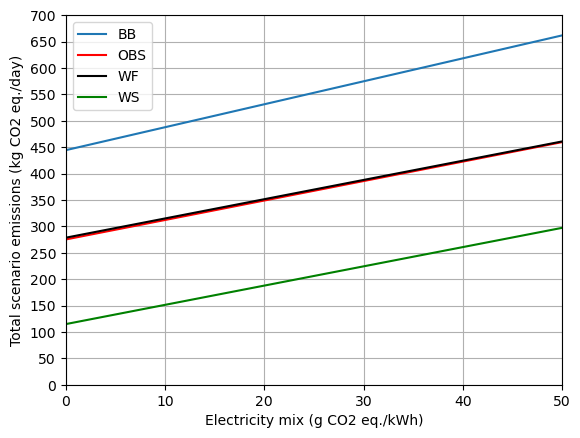

In [12]:
fig, ax = plt.subplots()

ax.plot(CO2_e, GHG_BB)
ax.plot(CO2_e, GHG_OBS, 'r')
ax.plot(CO2_e, GHG_WF, 'black')
ax.plot(CO2_e, GHG_WS, 'g')

ax.axis([0, 50, 0, 700])
ax.grid()
ax.set_xlabel('Electricity mix (g CO2 eq./kWh)')
ax.set_ylabel('Total scenario emissions (kg CO2 eq./day)')
ax.set_yticks(np.arange(0, 750, step=50))
ax.set_xticks([0,10,20,30,40,50])
ax.legend(['BB', 'OBS', 'WF', 'WS'])